## API de Ressarcimento Sinistro Automóvel (NLP de ressarcimento do sinistro)

##### Referencia

### "Somente quando um modelo está totalmente integrado aos sistemas de negócios, podemos extrair valor real de suas previsões". — Cristóvão Samiullah

https://www.freecodecamp.org/news/how-to-deploy-an-nlp-model-with-fastapi/

#### Probabilidade de um sinistro ser ressarcível

##### Importar os pacotes importantes

In [36]:
# import important modules
import numpy as np
import pandas as pd

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB # classifier 

from sklearn.metrics import (
    accuracy_score,
    classification_report
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# text preprocessing modules
from string import punctuation 

# text preprocessing modules
from nltk.tokenize import word_tokenize

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re #regular expression

# Download dependency
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)
    
import warnings
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package brown to /home/jovyan/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to /home/jovyan/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


##### Carregando conjunto de dados da pasta de dados:

In [14]:
# load data
colnames=['DESCRICAO', 'SITUAÇÃO DO SINISTRO']
colrenames={'DESCRICAO': 'review','SITUAÇÃO DO SINISTRO': 'situacao'}
#data = pd.read_csv("../data/base_de_descricoes.csv", usecols=colnames)
data = pd.read_csv("base_de_descricoes.csv", usecols=colnames)
data.rename(columns=colrenames, inplace=True)
data['situacao'] = data['situacao'].replace('SEGURADO CULPADO', 'BAIXADO COM RESSARCIMENTO')
data['sentiment'] = data['situacao'].replace('BAIXADO COM RESSARCIMENTO', 1).replace('BAIXADO SEM RESSARCIMENTO', 0)

##### Remove todas as linhas que contêm pelo menos um valor nulo

##### Nosso conjunto de dados tem 3 colunas:
| **Review** | **Situacao** | **Sentimento** |
|------------|--------------|----------------|
|Descrição aviso sinistro|Situação do sinistro| positivo (1) ou negativo (0) |

In [ ]:
data.dropna(inplace=True)
data.head() 


##### Verifica o tamnho do DataSet

In [16]:
# check the shape of the data
data.shape

(87885, 3)

##### Verificar se há valores nulos

In [17]:
# check missing values in data
data.isnull().sum()

review       0
situacao     0
sentiment    0
dtype: int64

##### Avaliar a distribuição do sentimento noticioso

In [18]:
# evalute news sentiment distribution
data.sentiment.value_counts()

sentiment
0    78181
1     9704
Name: count, dtype: int64

### Preparação de dados

In [19]:
import nltk
nltk.download('stopwords')
stop_words =  stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Limparemos as mensagens removendo palavras paradas, números e pontuação. Em seguida, converteremos cada palavra em sua forma base usando o processo de lemmatização no pacote NLTK.

In [20]:


def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)

##### Agora podemos limpar nosso conjunto de dados usando a função

In [ ]:
#clean the review
data["cleaned_review"] = data["review"].apply(text_cleaning)
data.head()

##### Dividimos os dados em variáveis de features e de target. Nosso recurso para treinamento é a variável cleaned_review e o alvo é a variável sentiment.

In [ ]:
features = data["cleaned_review"]
target = data.sentiment.values
features.head()

##### Em seguida, dividimos nosso conjunto de dados em dados de treinamento e teste. O tamanho do teste é 30% de todo o conjunto de dados.



In [23]:
# split data into train and validate

X_train, X_test, y_train, y_test= train_test_split(
    features,
    target,
    test_size=0.30,
    random_state=42,
    shuffle=True,
    stratify=target,
)

In [24]:
print(f"X_train dataset features size: {X_train.shape}")
print(f"X_test dataset label size: {X_test.shape}")
print(f"y_train dataset features size: {y_train.shape}")
print(f"y_test dataset features size: {y_test.shape}")

X_train dataset features size: (61519,)
X_test dataset label size: (26366,)
y_train dataset features size: (61519,)
y_test dataset features size: (26366,)


### Create Classifier 

##### Vamos treinar o algoritmo Multinomial RandomForestClassifier  para classificar se uma revisão é positiva ou negativa. Este é um dos algoritmos mais comuns usados para classificação de texto.

In [25]:
# Create a classifier in pipeline
sentiment_classifier = Pipeline(steps=[
                                 ('pre_processing',TfidfVectorizer(lowercase=False)),
                                 ('clf',RandomForestClassifier())
                                 ])

##### Treinar o classificador de sentimento

In [26]:
sentiment_classifier.fit(X_train,y_train)

Pipeline(steps=[('pre_processing', TfidfVectorizer(lowercase=False)),
                ('clf', RandomForestClassifier())])

##### Desempenho do modelo estimado em dados válidos

In [27]:
y_preds = sentiment_classifier.predict(X_test)

In [28]:
accuracy_score(y_test,y_preds)

0.8896305848441174

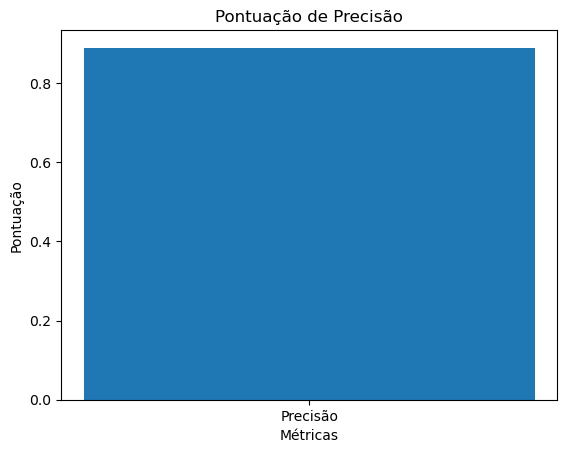

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Calcula a pontuação de precisão
score = accuracy_score(y_test, y_preds)

# Cria um gráfico de barras
plt.bar(['Precisão'], [score])
plt.title('Pontuação de Precisão')
plt.xlabel('Métricas')
plt.ylabel('Pontuação')
plt.show()

##### Traçar a matriz de confusão

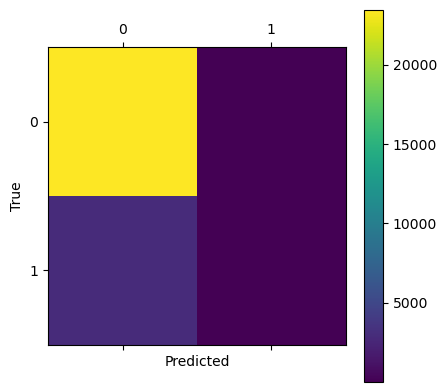

In [48]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_preds)
plt.matshow(cm, cmap='viridis')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

##### Confira o relatório de classificação

In [30]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     23455
           1       0.67      0.00      0.00      2911

    accuracy                           0.89     26366
   macro avg       0.78      0.50      0.47     26366
weighted avg       0.87      0.89      0.84     26366



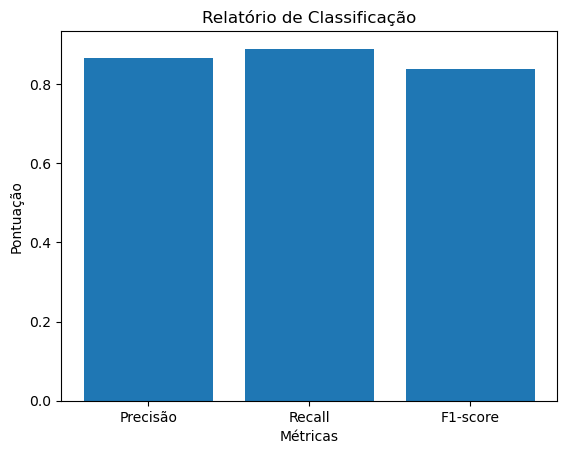

In [53]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Calcula o relatório de classificação
report = classification_report(y_test, y_preds, output_dict=True)

# Extrai as pontuações de precisão, recall e f1-score
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Cria um gráfico de barras
plt.bar(['Precisão', 'Recall', 'F1-score'], [precision, recall, f1_score])
plt.title('Relatório de Classificação')
plt.xlabel('Métricas')
plt.ylabel('Pontuação')
plt.show()


##### Salvar o pipeline de modelo

In [32]:
#save model 
import joblib 

joblib.dump(sentiment_classifier, 'sentiment_model_pipeline.pkl')

['sentiment_model_pipeline.pkl']

In [33]:
import joblib
pipe = joblib.load('sentiment_model_pipeline.pkl'
)

pipe

Pipeline(steps=[('pre_processing', TfidfVectorizer(lowercase=False)),
                ('clf', RandomForestClassifier())])

In [ ]:

posicao = 66 # 0 NA0 5 SIM 88 (SIM API com erro)

descricaoSinistro = data["cleaned_review"][posicao]
# clean the review
cleaned_review = text_cleaning(descricaoSinistro)
cleaned_review = [cleaned_review]
print(cleaned_review)
print(data['situacao'][posicao])
 

In [59]:
previsao = pipe.predict(cleaned_review)
output = int(previsao[0])
probas = pipe.predict_proba(cleaned_review)
output_probability = "{:.2f}".format(float(probas[:, output]))

# output dictionary
sentiments = {0: "NAO_RESSARCIVEL", 1: "RESSARCIVEL"}

# show results
result = {"ressarcivel": sentiments[output], "probabilidade": output_probability}
result

{'ressarcivel': 'NAO_RESSARCIVEL', 'probabilidade': '1.00'}

In [ ]:
print(data['situacao'])

In [61]:
posicao = 0 # 0 NA0 5 SIM 88 (SIM API com erro)

descricaoSinistro = data["cleaned_review"][posicao]
# clean the review
cleaned_review = text_cleaning(descricaoSinistro)
cleaned_review = [cleaned_review]
print(cleaned_review)
print(data['situacao'][posicao])

['A CONDUTORA DO VEICULO SEGURADO CONDUZIA SEU VEICULO PELA VIA CITADA MOMENTO EM QUE DEIXOU SEU VEICULO DEVIDAMENTE ESTACIONADO E AO RETORNAR O ENCONTROU DANIFICADO']
BAIXADO SEM RESSARCIMENTO


In [62]:
previsao = pipe.predict(cleaned_review)
output = int(previsao[0])
probas = pipe.predict_proba(cleaned_review)
output_probability = "{:.2f}".format(float(probas[:, output]))

# output dictionary
sentiments = {0: "NAO_RESSARCIVEL", 1: "RESSARCIVEL"}

# show results
result = {"ressarcivel": sentiments[output], "probabilidade": output_probability}
result

{'ressarcivel': 'NAO_RESSARCIVEL', 'probabilidade': '1.00'}